# V-bottom Well Motility Assay and Line Scan Analysis
---

### Overview

This notebook processes and analyzes motility assays of *Chlamydomonas* strains seeded in 96- or 384-well plates with v-bottom wells, using images captured by a [Phenotype-o-mat setup](https://doi.org/10.57844/arcadia-112f-5023). The output from the Phenotype-o-mat is a single-frame AVI file (i.e. a grayscale image) of all 96 or 384 v-bottom wells. The notebook performs several key functions:

1. **GIF creation from video files**:
   - Extracts AVI video frames from Phenotype-o-mat experiments, applies time stamps, and stitches them into time-lapsed GIFs for visual inspection of motility over time.

2. **Line scan intensity analysis**:
   - Conducts horizontal line scans across the wells to quantify cell density, differentiating between non-motile cells (which sink to the bottom of the well) and motile cells (which remain suspended). Metrics such as minimum intensity, average intensity, and their differences/ratios are computed for further analysis.

3. **Visualization and statistical testing**:
   - Annotates and displays the processed well images, overlays line scan plots, violin plots of motility fractions, and performs either Kruskal-Wallis and Dunn's post-hoc tests with Bonferroni correction or one-way ANOVA and post-hoc Tukey tests to evaluate differences between treatments across multiple strains.

Output from this notebook was used to generate figures and statistical analyses related to cell motility for the study, contributing to Figures 2 and 4 in the [publication](https://doi.org/10.57844/arcadia-fe2a-711e).

ChatGPT was used draft the scripts in this notebook.

## 1. GIF creation from video files
---

In [1]:
%run ../src/scripts/create_vbottom_gifs.py \
    --zipfolder "../data/vbottom_motility_assay/vbottom_motility_strains.zip" \
    --gif "../results/vbottom_strain_output_video.gif"

%run ../src/scripts/create_vbottom_gifs.py \
    --zipfolder "../data/vbottom_motility_assay/vbottom_motility_treatment.zip" \
    --gif "../results/vbottom_treatment_output_video.gif"

Files extracted to: ../data/vbottom_motility_assay/vbottom_motility_strains
Outputting GIF to: ../results/vbottom_strain_output_video.gif
Processing 96 files...
GIF creation complete.
Files extracted to: ../data/vbottom_motility_assay/vbottom_motility_treatment
Outputting GIF to: ../results/vbottom_treatment_output_video.gif
Processing 96 files...
GIF creation complete.


## 2. Line scan intensity analysis (Figure 2)
---
Prior to this analysis, I opened the last single-frame AVI acquired in the dataset in FIJI and cropped the image to only include the wells of interest. I then saved the image as a TIF. 

### Purpose:
This code performs line scan analyses on an image of a 384-well v-bottom plate seeded with *Chlamydomonas* strains to measure cell density and motility defects. It visualizes, compares, and exports data for statistical analysis across three strains (`CC-125`, `CC-2670`, `CC-3707`).

### Key Steps:
1. **Image Handling**

2. **Visualization**
 
3. **Data Processing**

4. **Statistical Analysis**

5. **Plotting**

### Outputs:
- **Marked Images**: PNG files with scanned lines and labels.
- **Plots**: SVGs showing either overlaid line scans for each strain or the distribution of motility fractions for each strain.
- **Data Files**: CSVs with line scan intensities and statistical comparison results.

### Libraries:
- `tifffile`, `opencv`, `matplotlib`, `pandas`, `scipy.stats`, `arcadia-pycolor`, `seaborn`, `os`, `itertools`, `pathlib`, `numpy`, `scikit_posthocs`, `skimage.draw`, `statsmodels.stats.multicomp`, `matplotlip.patches`.

In [2]:
from itertools import combinations
from pathlib import Path

import os
import seaborn as sns
import arcadia_pycolor as apc
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import tifffile
import scikit_posthocs as sp
from matplotlib.patches import Rectangle
from skimage.draw import line
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Set the default matplotlib styles using arcadia-pycolor
apc.mpl.setup()

### Image Handling
   - Loads a TIFF image of a plate and identifies well centers.
   - Performs horizontal line scans through each well, aligning scans by minimum intensity (representing non-motile cells).

In [3]:
# Load the TIFF file
image_path = "../data/vbottom_motility_assay/cropped_final_frames/algae_growth_curve_00000_1722972387-1_FinalFrame_Crop.tif"  # noqa: E501
image = tifffile.imread(image_path)

# Convert the image to grayscale if it's not already
if len(image.shape) > 2:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define the number of rows and columns in the well plate you want to analyze
num_rows = 6
num_cols = 11

# Diameter and scan width of the wells
well_diameter = 70
scan_width = 10
scan_length = 40

# Identify the centers of the wells
height, width = image.shape
row_spacing = height // num_rows
col_spacing = width // num_cols

# Calculate precise center positions of the wells
well_centers = [
    (int((row + 0.5) * row_spacing), int((col + 0.5) * col_spacing))
    for row in range(num_rows)
    for col in range(num_cols)
]

# Create a list to store the line scan results
line_scans = []

# Perform line scans, realign, and normalize data
for _i, (center_y, center_x) in enumerate(well_centers):
    start_x = max(center_x - scan_length // 2, 0)
    end_x = min(center_x + scan_length // 2, width - 1)

    # Perform a horizontal line scan across the center with a width of scan_width
    line_intensity = []
    for offset in range(-scan_width // 2, scan_width // 2 + 1):
        rr, cc = line(center_y + offset, start_x, center_y + offset, end_x)
        line_intensity.append(image[rr, cc])

    # Ensure all scans are of the same length by trimming to scan_length
    line_intensity = [scan[:scan_length] for scan in line_intensity]
    line_intensity = np.mean(line_intensity, axis=0)

    # Realign the line scan by aligning the minimum point within a broader search region
    broader_search_indices = np.arange(10, 30)
    min_index = broader_search_indices[np.argmin(line_intensity[broader_search_indices])]
    shift = (scan_length // 2) - min_index
    line_intensity = np.roll(line_intensity, shift)

    # Store the realigned and normalized result
    line_scans.append(line_intensity)

# Convert the line scan results to a DataFrame and export as CSV
line_scans_df = pd.DataFrame(line_scans).T
well_labels = [f"Well {row+1}-{col+1}" for row in range(num_rows) for col in range(num_cols)]
line_scans_df.columns = well_labels
csv_path = "../results/linescan_strain_results/line_scans.csv"
line_scans_df.to_csv(csv_path, index=False)

### Normalization
 - Calculate the average intensity of each line scan and divide each scan by its corresponding average to normalize the values.
 - Save the normalized line scans as a CSV file for further analysis.

In [4]:
# Calculate the average intensity for each scan
average_intensities = [np.mean(scan) for scan in line_scans]

# Normalize the line scans based on the average intensity of each scan
normalized_line_scans = [scan / avg_intensity for scan, avg_intensity in zip(line_scans, average_intensities)]

# Convert the normalized line scan results to a DataFrame and export as a new CSV
normalized_line_scans_df = pd.DataFrame(normalized_line_scans).T
normalized_line_scans_df.columns = well_labels
normalized_csv_path = "../results/linescan_strain_results/normalized_line_scans.csv"
normalized_line_scans_df.to_csv(normalized_csv_path, index=False)

print(f"Normalized line scans saved to: {normalized_csv_path}")

Normalized line scans saved to: ../results/linescan_strain_results/normalized_line_scans.csv


### Visualization
  - Draws scanned lines and sample labels on the image.
   - Saves and displays marked images with scan lines and detailed well information.

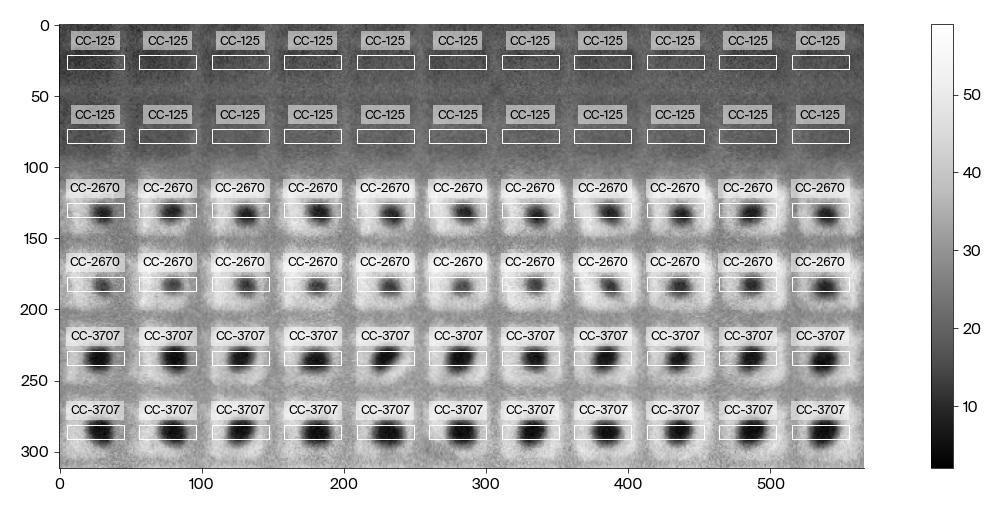

In [5]:
# Updated labels for each well
labels = [
    ["CC-125"] * num_cols,
    ["CC-125"] * num_cols,
    ["CC-2670"] * num_cols,
    ["CC-2670"] * num_cols,
    ["CC-3707"] * num_cols,
    ["CC-3707"] * num_cols,
]
flat_labels = [label for row in labels for label in row]

# Create figure
fig, ax = plt.subplots(figsize=(24, 8))

# Plot plate image
im = ax.imshow(image, cmap="Greys_r")
fig.colorbar(im)

# Loop through each well
i = 0
for well_center, label in zip(well_centers, flat_labels, strict=True):
    # Annotate the region that the intensity was scanned
    anchor_point = (well_center[1] - scan_length / 2, well_center[0] - scan_width / 2)
    scan_region = Rectangle(
        xy=anchor_point,
        width=scan_length,
        height=scan_width,
        linewidth=1,
        edgecolor="white",
        facecolor="none",
    )
    ax.add_patch(scan_region)

    # Annotate each region with the strain name
    ax.text(
        x=well_center[1],
        y=well_center[0] - 15,
        s=label,
        ha="center",
        va="center",
        fontsize=12,
        color="black",
        bbox={"facecolor": "white", "alpha": 0.5},
    )

    i += 1

image_path = "../results/linescan_strain_results/vbottom_wells_annotated.png"
apc.mpl.save_figure(image_path)

### Data Processing
   - Computes pixel intensity averages for the maximum intensity values (specified as pixel positions 33-37), minimum intensity values, and the ratio of these values (Motility Ratio).
   - Exports line scan results to CSV.

In [6]:
# Define end tail of the line scan where only motile cells will be
pixel_range = range(33, 38)

# Create lists to store the values for each well (raw and normalized)
pixel_33_37_values = []
pixel_33_37_avg_list = []
min_value_list = []
difference_list = []
fraction_list = []

normalized_pixel_33_37_values = []
normalized_pixel_33_37_avg_list = []
normalized_min_value_list = []
normalized_difference_list = []
normalized_fraction_list = []

# Loop over each scan to calculate the statistics
for raw_scan, norm_scan in zip(line_scans, normalized_line_scans):
    # Raw data calculations
    pixel_33_37 = raw_scan[33:38]
    pixel_33_37_values.append(list(pixel_33_37))
    pixel_33_37_avg = np.mean(pixel_33_37)
    pixel_33_37_avg_list.append(pixel_33_37_avg)
    min_value = np.min(raw_scan)
    min_value_list.append(min_value)
    difference = pixel_33_37_avg - min_value
    difference_list.append(difference)
    fraction = pixel_33_37_avg / min_value if min_value != 0 else np.nan
    fraction_list.append(fraction)

    # Normalized data calculations
    norm_pixel_33_37 = norm_scan[33:38]
    normalized_pixel_33_37_values.append(list(norm_pixel_33_37))
    norm_pixel_33_37_avg = np.mean(norm_pixel_33_37)
    normalized_pixel_33_37_avg_list.append(norm_pixel_33_37_avg)
    norm_min_value = np.min(norm_scan)
    normalized_min_value_list.append(norm_min_value)
    norm_difference = norm_pixel_33_37_avg - norm_min_value
    normalized_difference_list.append(norm_difference)
    norm_fraction = norm_pixel_33_37_avg / norm_min_value if norm_min_value != 0 else np.nan
    normalized_fraction_list.append(norm_fraction)

# Create DataFrames and export to CSV files
export_df = pd.DataFrame({
    "Well": [f"Well {row+1}-{col+1}" for row in range(num_rows) for col in range(num_cols)],
    "Strain": flat_labels,
    "Pixel_33_37_Values": pixel_33_37_values,
    "Pixel_33_37_Avg": pixel_33_37_avg_list,
    "Min_Value": min_value_list,
    "Difference_33_37_Avg_Min": difference_list,
    "Fraction_33_37_Avg_Min": fraction_list,
})

normalized_export_df = pd.DataFrame({
    "Well": [f"Well {row+1}-{col+1}" for row in range(num_rows) for col in range(num_cols)],
    "Strain": flat_labels,
    "Normalized_Pixel_33_37_Values": normalized_pixel_33_37_values,
    "Normalized_Pixel_33_37_Avg": normalized_pixel_33_37_avg_list,
    "Normalized_Min_Value": normalized_min_value_list,
    "Normalized_Difference_33_37_Avg_Min": normalized_difference_list,
    "Normalized_Fraction_33_37_Avg_Min": normalized_fraction_list,
})

# Export the data to CSV files
csv_path = "../results/linescan_strain_results/pixel_33_37_min_comparisons.csv"
export_df.to_csv(csv_path, index=False)
print(f"Pixel comparison data saved to: {csv_path}")

normalized_csv_path = "../results/linescan_strain_results/normalized_pixel_33_37_min_comparisons.csv"
normalized_export_df.to_csv(normalized_csv_path, index=False)
print(f"Normalized pixel comparison data saved to: {normalized_csv_path}")

Pixel comparison data saved to: ../results/linescan_strain_results/pixel_33_37_min_comparisons.csv
Normalized pixel comparison data saved to: ../results/linescan_strain_results/normalized_pixel_33_37_min_comparisons.csv


### Statistical Analysis
   - Conducts Kruskal-Wallis H-tests with Dunn's post-hoc test with Bonferroni correction for pairwise strain comparisons of motility ratios.


In [7]:
# List of strains
strains = ["CC-125", "CC-2670", "CC-3707"]

# Collect data for each strain (raw and normalized)
group_data = []
normalized_group_data = []
for strain in strains:
    strain_fraction = export_df[export_df["Strain"] == strain]["Fraction_33_37_Avg_Min"]
    group_data.append(strain_fraction)
    norm_strain_fraction = normalized_export_df[normalized_export_df["Strain"] == strain]["Normalized_Fraction_33_37_Avg_Min"]
    normalized_group_data.append(norm_strain_fraction)

# Perform Kruskal-Wallis test on raw data
statistic_raw, p_value_raw = stats.kruskal(*group_data)
print("Kruskal-Wallis H-test result (raw data):")
print(f"H-statistic: {statistic_raw:.4f}, p-value: {p_value_raw:.4f}")

# Perform Kruskal-Wallis test on normalized data
statistic_norm, p_value_norm = stats.kruskal(*normalized_group_data)
print("\nKruskal-Wallis H-test result (normalized data):")
print(f"H-statistic: {statistic_norm:.4f}, p-value: {p_value_norm:.4f}")

# If significant, perform Dunn's post-hoc test
if p_value_raw < 0.05:
    print("\nPerforming Dunn's post-hoc test on raw data.")
    data_combined = pd.concat(group_data, axis=0, ignore_index=True)
    groups = [strain for strain, group in zip(strains, group_data) for _ in range(len(group))]
    dunn_data = pd.DataFrame({"values": data_combined, "groups": groups})
    dunn_results_raw = sp.posthoc_dunn(dunn_data, val_col="values", group_col="groups", p_adjust='bonferroni')
    print("\nDunn's post-hoc test results (raw data):")
    print(dunn_results_raw)

if p_value_norm < 0.05:
    print("\nPerforming Dunn's post-hoc test on normalized data.")
    normalized_data_combined = pd.concat(normalized_group_data, axis=0, ignore_index=True)
    normalized_groups = [strain for strain, group in zip(strains, normalized_group_data) for _ in range(len(group))]
    normalized_dunn_data = pd.DataFrame({"values": normalized_data_combined, "groups": normalized_groups})
    dunn_results_norm = sp.posthoc_dunn(normalized_dunn_data, val_col="values", group_col="groups", p_adjust='bonferroni')
    print("\nDunn's post-hoc test results (normalized data):")
    print(dunn_results_norm)

Kruskal-Wallis H-test result (raw data):
H-statistic: 57.7910, p-value: 0.0000

Kruskal-Wallis H-test result (normalized data):
H-statistic: 57.7910, p-value: 0.0000

Performing Dunn's post-hoc test on raw data.

Dunn's post-hoc test results (raw data):
               CC-125   CC-2670       CC-3707
CC-125   1.000000e+00  0.000432  8.744813e-14
CC-2670  4.323031e-04  1.000000  4.323031e-04
CC-3707  8.744813e-14  0.000432  1.000000e+00

Performing Dunn's post-hoc test on normalized data.

Dunn's post-hoc test results (normalized data):
               CC-125   CC-2670       CC-3707
CC-125   1.000000e+00  0.000432  8.744813e-14
CC-2670  4.323031e-04  1.000000  4.323031e-04
CC-3707  8.744813e-14  0.000432  1.000000e+00


### Plotting Raw Values
   - Generates overlaid plots of line scans for each strain and saves as SVG.


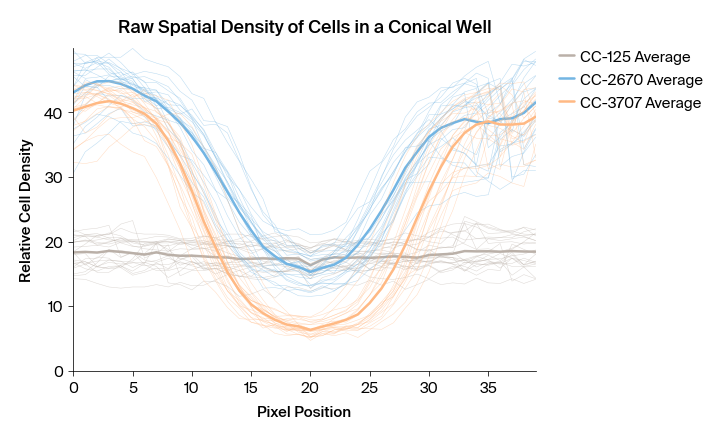

Overlayed plot saved to: ../results/linescan_strain_results/overlayed_plot_all_strains_raw.svg


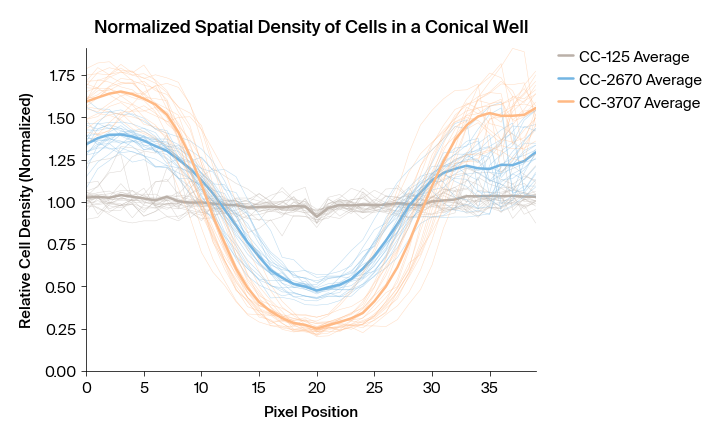

Overlayed plot of normalized data saved to: ../results/linescan_strain_results/overlayed_plot_all_strains_normalized.svg


In [8]:
# Define color scheme for each strain
strain_color_map = {"CC-125": "#BAB0A8", "CC-2670": "#73B5E3", "CC-3707": "#FFB984"}

# Find global min and max for y-axis across raw and normalized scans
y_max_raw = max([max(scan) for scan in line_scans])
y_max_norm = max([max(scan) for scan in normalized_line_scans])

# Create plot with all 3 strain measurements overlaid (raw)
fig, ax = plt.subplots(figsize=(10, 6))
for strain in strains:
    strain_scans = [line_scans[i] for i in range(len(line_scans)) if flat_labels[i] == strain]
    for scan in strain_scans:
        ax.plot(scan, color=strain_color_map[strain], linewidth=0.5, alpha=0.5)
    if strain_scans:
        avg_scan = np.mean(strain_scans, axis=0)
        ax.plot(avg_scan, color=strain_color_map[strain], linewidth=2.5, label=f"{strain} Average")

ax.set_xlim(0, scan_length - 1)
ax.set_ylim(0, y_max_raw)
ax.set_title("Raw Spatial Density of Cells in a Conical Well", fontstyle="normal")
ax.set_xlabel("Pixel Position")
ax.set_ylabel("Relative Cell Density")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()
raw_overlayed_plot_path = "../results/linescan_strain_results/overlayed_plot_all_strains_raw.svg"
plt.savefig(raw_overlayed_plot_path, format="svg")
plt.show()
print(f"Overlayed plot saved to: {raw_overlayed_plot_path}")

# Create plot with all 3 strain measurements overlaid (normalized)
fig, ax = plt.subplots(figsize=(10, 6))
for strain in strains:
    norm_strain_scans = [normalized_line_scans[i] for i in range(len(normalized_line_scans)) if flat_labels[i] == strain]
    for scan in norm_strain_scans:
        ax.plot(scan, color=strain_color_map[strain], linewidth=0.5, alpha=0.5)
    if norm_strain_scans:
        avg_scan = np.mean(norm_strain_scans, axis=0)
        ax.plot(avg_scan, color=strain_color_map[strain], linewidth=2.5, label=f"{strain} Average")

ax.set_xlim(0, scan_length - 1)
ax.set_ylim(0, y_max_norm)
ax.set_title("Normalized Spatial Density of Cells in a Conical Well", fontstyle="normal")
ax.set_xlabel("Pixel Position")
ax.set_ylabel("Relative Cell Density (Normalized)")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()
normalized_overlayed_plot_path = "../results/linescan_strain_results/overlayed_plot_all_strains_normalized.svg"
plt.savefig(normalized_overlayed_plot_path, format="svg")
plt.show()
print(f"Overlayed plot of normalized data saved to: {normalized_overlayed_plot_path}")

### Plotting Motility Fractions
   - Generates violin plots showing the distribution of motility ratios between species. Plot is saved as an SVG


/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_40545/4131726766.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="groups", y="values", data=plot_data,


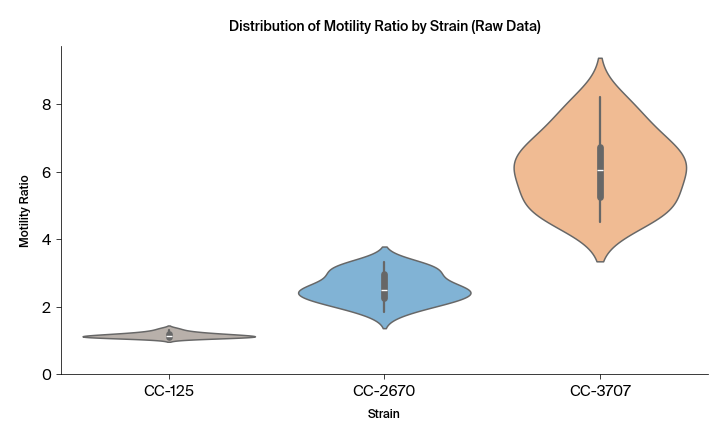

Violin plot of raw data saved to: ../results/linescan_strain_results/strains_violin_raw.svg


/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_40545/4131726766.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="groups", y="values", data=normalized_plot_data,


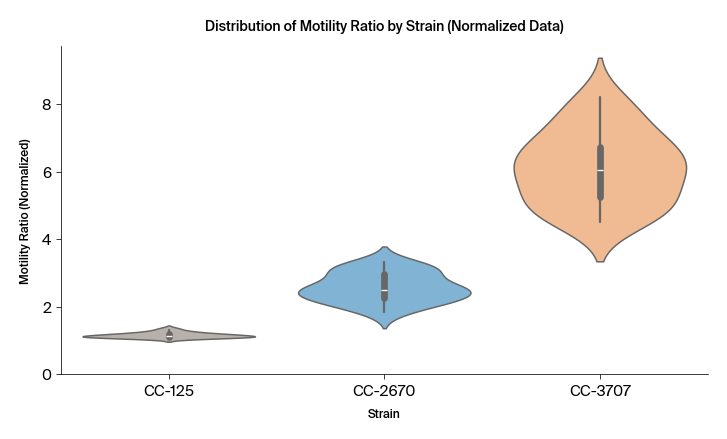

Violin plot of normalized data saved to: ../results/linescan_strain_results/strains_violin_normalized.svg


In [9]:
# Prepare the data for violin plot (raw and normalized)
data_combined = pd.concat(group_data, axis=0, ignore_index=True)
normalized_data_combined = pd.concat(normalized_group_data, axis=0, ignore_index=True)

groups = [strain for strain, group in zip(strains, group_data) for _ in range(len(group))]
normalized_groups = [strain for strain, group in zip(strains, normalized_group_data) for _ in range(len(group))]

plot_data = pd.DataFrame({"values": data_combined, "groups": groups})
normalized_plot_data = pd.DataFrame({"values": normalized_data_combined, "groups": normalized_groups})

# Create violin plot for raw data
plt.figure(figsize=(10, 6))
sns.violinplot(x="groups", y="values", data=plot_data,
               palette=strain_color_map, inner="box", linewidth=1.5)
plt.title("Distribution of Motility Ratio by Strain (Raw Data)", fontsize=14)
plt.xlabel("Strain", fontsize=12)
plt.ylabel("Motility Ratio", fontsize=12)
plt.ylim(0, None)
plt.tight_layout()
raw_violin_path = "../results/linescan_strain_results/strains_violin_raw.svg"
plt.savefig(raw_violin_path, format="svg")
plt.show()
print(f"Violin plot of raw data saved to: {raw_violin_path}")

# Create violin plot for normalized data
plt.figure(figsize=(10, 6))
sns.violinplot(x="groups", y="values", data=normalized_plot_data,
               palette=strain_color_map, inner="box", linewidth=1.5)
plt.title("Distribution of Motility Ratio by Strain (Normalized Data)", fontsize=14)
plt.xlabel("Strain", fontsize=12)
plt.ylabel("Motility Ratio (Normalized)", fontsize=12)
plt.ylim(0, None)
plt.tight_layout()
normalized_violin_path = "../results/linescan_strain_results/strains_violin_normalized.svg"
plt.savefig(normalized_violin_path, format="svg")
plt.show()
print(f"Violin plot of normalized data saved to: {normalized_violin_path}")

---

## Data Analysis - Intensity line scan (Figure 4)
Prior to this analysis, I opened the last single-frame AVI acquired in the dataset in FIJI and cropped the image to only include the wells of interest. I then saved the image as a TIF. 
### Purpose:
This code performs line scan analyses on an image of a 96-well plate seeded with *Chlamydomonas* strains under various treatments to measure cell density and motility defects.

### Key Steps:
1. **Image Handling**

2. **Visualization**

3. **Data Processing**

4. **Plotting**

5. **Statistical Analysis**


### Outputs:
- **Marked Images**: PNG files with visualized line scans and well labels.
- **Line Scan Plots**: SVGs files showing either the overlayed line scans for each strain and treatment or the distribution of motility ratios between treatments for each strain.
- **Data Files**: CSVs with line scan intensities, minimum intensity points, and statistical results.

### Libraries:
- `tifffile`, `opencv`, `matplotlib`, `pandas`, `scipy.stats`, `arcadia-pycolor`, `seaborn`, `os`, `itertools`, `pathlib`, `numpy`, `scikit_posthocs`, `skimage.draw`, `statsmodels.stats.multicomp`, `matplotlip.patches`.

This script automates image analysis, statistical testing, and visualization for line scans in a 96-well plate of *Chlamydomonas* strains treated with various compounds.


### Image Handling

- Loads and verifies a TIFF image, converting it to grayscale if needed.
- Calculates well center positions and generates labels for each well in a 6x12 grid.

In [10]:
# Filepath to the TIFF file
image_path = "../data/vbottom_motility_assay/cropped_final_frames/algae_growth_curve_00000_1724619978-Crop.tif"  # noqa: E501
image = tifffile.imread(image_path)

# Convert the image to grayscale
if len(image.shape) > 2:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define the number of rows and columns in the plate
num_rows = 6
num_cols = 12

# Diameter and scan width of the wells
well_diameter = 70
scan_width = 10
scan_length = 40

# Identify the centers of the wells
height, width = image.shape
row_spacing = height // num_rows
col_spacing = width // num_cols

# Calculate precise center positions of the wells
well_centers = [
    (int((row + 0.5) * row_spacing), int((col + 0.5) * col_spacing))
    for row in range(num_rows)
    for col in range(num_cols)
]

# Create a list of well labels
well_labels = [f"Well {row+1}-{col+1}" for row in range(num_rows) for col in range(num_cols)]

### Visualization
- Draws line scans and labels wells with strain and treatment information.
- Saves and displays the modified images with line scans and labels.

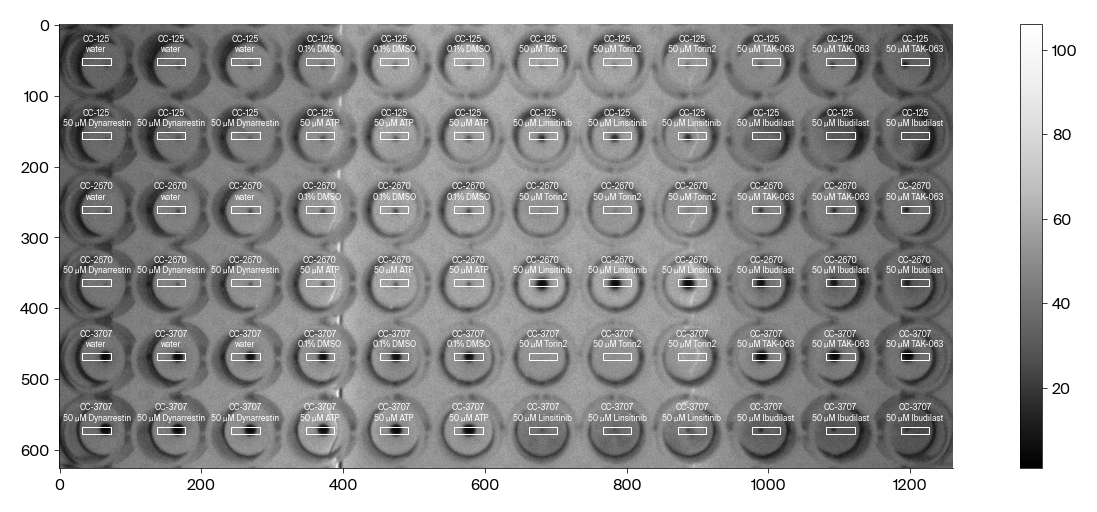

In [11]:
# Indicate labels for each well (strain and treatment)
labels = [
    [
        "CC-125\nwater",
        "CC-125\nwater",
        "CC-125\nwater",
        "CC-125\n0.1% DMSO",
        "CC-125\n0.1% DMSO",
        "CC-125\n0.1% DMSO",
        "CC-125\n50 µM Torin2",
        "CC-125\n50 µM Torin2",
        "CC-125\n50 µM Torin2",
        "CC-125\n50 µM TAK-063",
        "CC-125\n50 µM TAK-063",
        "CC-125\n50 µM TAK-063",
    ],
    [
        "CC-125\n50 µM Dynarrestin",
        "CC-125\n50 µM Dynarrestin",
        "CC-125\n50 µM Dynarrestin",
        "CC-125\n50 µM ATP",
        "CC-125\n50 µM ATP",
        "CC-125\n50 µM ATP",
        "CC-125\n50 µM Linsitinib",
        "CC-125\n50 µM Linsitinib",
        "CC-125\n50 µM Linsitinib",
        "CC-125\n50 µM Ibudilast",
        "CC-125\n50 µM Ibudilast",
        "CC-125\n50 µM Ibudilast",
    ],
    [
        "CC-2670\nwater",
        "CC-2670\nwater",
        "CC-2670\nwater",
        "CC-2670\n0.1% DMSO",
        "CC-2670\n0.1% DMSO",
        "CC-2670\n0.1% DMSO",
        "CC-2670\n50 µM Torin2",
        "CC-2670\n50 µM Torin2",
        "CC-2670\n50 µM Torin2",
        "CC-2670\n50 µM TAK-063",
        "CC-2670\n50 µM TAK-063",
        "CC-2670\n50 µM TAK-063",
    ],
    [
        "CC-2670\n50 µM Dynarrestin",
        "CC-2670\n50 µM Dynarrestin",
        "CC-2670\n50 µM Dynarrestin",
        "CC-2670\n50 µM ATP",
        "CC-2670\n50 µM ATP",
        "CC-2670\n50 µM ATP",
        "CC-2670\n50 µM Linsitinib",
        "CC-2670\n50 µM Linsitinib",
        "CC-2670\n50 µM Linsitinib",
        "CC-2670\n50 µM Ibudilast",
        "CC-2670\n50 µM Ibudilast",
        "CC-2670\n50 µM Ibudilast",
    ],
    [
        "CC-3707\nwater",
        "CC-3707\nwater",
        "CC-3707\nwater",
        "CC-3707\n0.1% DMSO",
        "CC-3707\n0.1% DMSO",
        "CC-3707\n0.1% DMSO",
        "CC-3707\n50 µM Torin2",
        "CC-3707\n50 µM Torin2",
        "CC-3707\n50 µM Torin2",
        "CC-3707\n50 µM TAK-063",
        "CC-3707\n50 µM TAK-063",
        "CC-3707\n50 µM TAK-063",
    ],
    [
        "CC-3707\n50 µM Dynarrestin",
        "CC-3707\n50 µM Dynarrestin",
        "CC-3707\n50 µM Dynarrestin",
        "CC-3707\n50 µM ATP",
        "CC-3707\n50 µM ATP",
        "CC-3707\n50 µM ATP",
        "CC-3707\n50 µM Linsitinib",
        "CC-3707\n50 µM Linsitinib",
        "CC-3707\n50 µM Linsitinib",
        "CC-3707\n50 µM Ibudilast",
        "CC-3707\n50 µM Ibudilast",
        "CC-3707\n50 µM Ibudilast",
    ],
]
flat_labels = [label for row in labels for label in row]

# Create figure
fig, ax = plt.subplots(figsize=(24, 8))

# Plot plate image
im = ax.imshow(image, cmap="Greys_r")
fig.colorbar(im)

# Loop through each well
i = 0
for well_center, label in zip(well_centers, flat_labels, strict=True):
    # Annotate the region that the intensity was scanned
    anchor_point = (well_center[1] - scan_length / 2, well_center[0] - scan_width / 2)
    scan_region = Rectangle(
        xy=anchor_point,
        width=scan_length,
        height=scan_width,
        linewidth=1,
        edgecolor="white",
        facecolor="none",
    )
    ax.add_patch(scan_region)

    # Annotate each region with the strain name
    ax.text(
        x=well_center[1],
        y=well_center[0] - 25,
        s=label,
        ha="center",
        va="center",
        fontsize=8,
        color="white",
    )

    i += 1

output_dir = Path("../results/linescan_drug_results/")
image_path = output_dir / "vbottom_wells_annotated.png"
apc.mpl.save_figure(image_path, dpi=192)

### Data Processing
- Performs horizontal line scans for each well, realigns based on minimum intensity.
- Calculates and stores metrics: average intensity, minimum intensity, difference, and fraction.

In [12]:
# Perform line scans, calculate metrics (minimum intensity, difference, and fraction)
line_scans = []
min_intensity_points = []
diff_avg_min = []
frac_avg_min = []

for i, (center_y, center_x) in enumerate(well_centers):
    # Calculate the start and end points of the scan line
    start_x = max(center_x - scan_length // 2, 0)
    end_x = min(center_x + scan_length // 2, width - 1)

    # Perform a horizontal line scan across the center with a width of scan_width
    line_intensity = []
    for offset in range(-scan_width // 2, scan_width // 2 + 1):
        rr, cc = line(center_y + offset, start_x, center_y + offset, end_x)
        line_intensity.append(image[rr, cc])

    # Ensure all scans are of the same length by trimming to scan_length
    line_intensity = [scan[:scan_length] for scan in line_intensity]
    line_intensity = np.mean(line_intensity, axis=0)

    # Realign the line scan by aligning the minimum point within a broader search region
    broader_search_indices = np.arange(10, 30)  # Adjusted for new scan length
    min_index = broader_search_indices[np.argmin(line_intensity[broader_search_indices])]
    shift = (scan_length // 2) - min_index  # Align the minimum point to the center
    line_intensity = np.roll(line_intensity, shift)

    # Store the realigned and normalized result
    line_scans.append(line_intensity)

    # Calculate the metrics:
    avg_33_37 = np.mean(line_intensity[33:38])  # Average between pixels 33-37
    min_intensity = np.min(line_intensity)  # Minimum intensity point
    diff_avg_min.append(avg_33_37 - min_intensity)  # Difference between avg (33-37) and min
    frac_avg_min.append(
        avg_33_37 / min_intensity if min_intensity != 0 else np.nan
    )  # Fraction of avg over min

    # Store the minimum intensity point with its strain and treatment
    min_intensity_points.append(
        {
            "Well": well_labels[i],
            "Strain": flat_labels[i].split("\n")[0],
            "Treatment": flat_labels[i].split("\n")[1],
            "Min_Intensity": min_intensity,
        }
    )

# Convert the line scan results to a DataFrame and export as CSV
line_scans_df = pd.DataFrame(line_scans).T
well_labels = [f"Well {row+1}-{col+1}" for row in range(num_rows) for col in range(num_cols)]
line_scans_df.columns = well_labels
csv_path = output_dir / "line_scans.csv"
line_scans_df.to_csv(csv_path, index=False)

### Plotting Raw Values
- Plots individual and average line scans for each strain and treatment.
- Saves each strain's plot as an SVG file and displays the result.

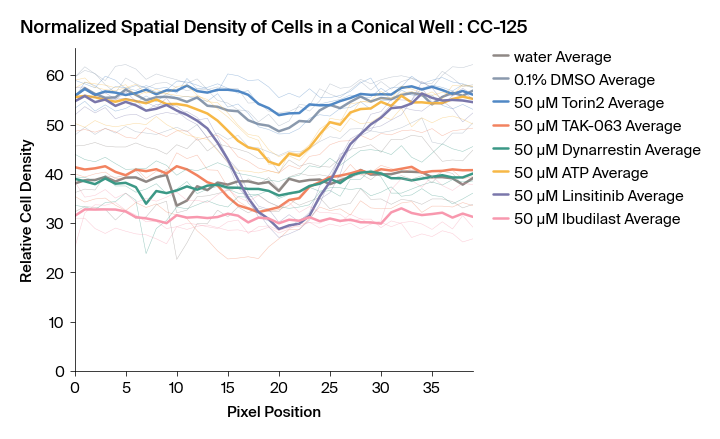

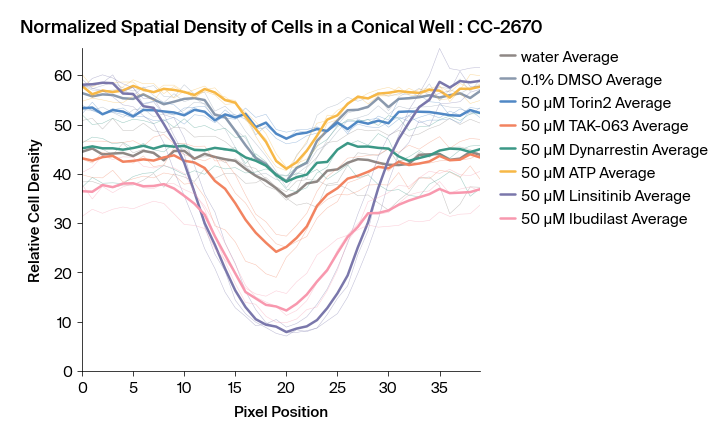

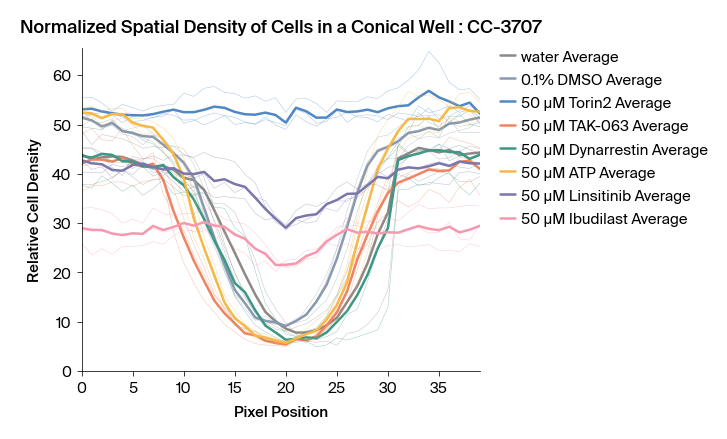

In [13]:
# Define the color scheme for treatments
treatment_color_map = {
    "water": "#8F8885",
    "0.1% DMSO": "#8A99AD",
    "50 µM Torin2": "#5088C5",
    "50 µM TAK-063": "#F28360",
    "50 µM Dynarrestin": "#3B9886",
    "50 µM ATP": "#F7B846",
    "50 µM Linsitinib": "#7A77AB",
    "50 µM Ibudilast": "#F898AE",
}

# Find the global minimum and maximum for y-axis across all scans
y_min = min([min(scan) for scan in line_scans])
y_max = max([max(scan) for scan in line_scans])

# Create separate plots for each strain with different treatments
for strain in ["CC-125", "CC-2670", "CC-3707"]:
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot individual scans and averages for each treatment in the current strain
    for treatment in treatment_color_map.keys():
        # Filter the scans that match the current strain and treatment
        treatment_scans = [
            line_scans[i]
            for i in range(len(line_scans))
            if flat_labels[i].split("\n")[0] == strain
            and flat_labels[i].split("\n")[1] == treatment
        ]

        # Plot the individual scans
        for scan in treatment_scans:
            ax.plot(scan, color=treatment_color_map[treatment], linewidth=0.5, alpha=0.5)

        # Plot the average scan
        if treatment_scans:
            avg_scan = np.mean(treatment_scans, axis=0)
            ax.plot(
                avg_scan,
                color=treatment_color_map[treatment],
                linewidth=2.5,
                label=f"{treatment} Average",
            )

    # Set consistent limits for x and y axes
    ax.set_xlim(0, scan_length - 1)
    ax.set_ylim(0, y_max)

    ax.set_title(
        f"Normalized Spatial Density of Cells in a Conical Well : {strain}", fontstyle="normal"
    )
    ax.set_xlabel("Pixel Position")
    ax.set_ylabel("Relative Cell Density")

    # Place the legend outside of the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)

    plt.tight_layout()

    # Save the plot as an SVG file
    overlayed_plot_path = os.path.join(output_dir, f"overlayed_plot_{strain}.svg")
    plt.savefig(overlayed_plot_path, format="svg")

    plt.show()

### Statistical Analysis
- Exports minimum intensity data and associated metrics (difference, fraction) to a CSV file.
- Performs ANOVA and Tukey’s HSD for statistical analysis on each strain and metric, saving the results to a CSV file.

In [14]:
# Export minimum intensity points as a CSV file
min_intensity_df = pd.DataFrame(min_intensity_points)
min_intensity_df["Diff_Avg_Min"] = diff_avg_min
min_intensity_df["Frac_Avg_Min"] = frac_avg_min

min_intensity_csv_path = output_dir / "min_intensity_points.csv"
min_intensity_df.to_csv(min_intensity_csv_path, index=False)

print(f"Minimum intensity points saved to: {min_intensity_csv_path}")

# Initialize a list to store the statistical results
stats_results = []

# Independent Statistical Analysis for Each Strain and Metric
for strain in ["CC-125", "CC-2670", "CC-3707"]:
    print(f"\n--- Statistical Analysis for {strain} ---")
    strain_data = min_intensity_df[min_intensity_df["Strain"] == strain]

    # Descriptive statistics for each metric
    desc_stats = strain_data.groupby("Treatment").describe()
    print(desc_stats)

    # Loop over the three metrics (Min_Intensity, Diff_Avg_Min, Frac_Avg_Min)
    for metric in ["Min_Intensity", "Diff_Avg_Min", "Frac_Avg_Min"]:
        print(f"\n--- ANOVA and Tukey for {metric} ---")

        # One-way ANOVA
        anova_result = stats.f_oneway(
            *[
                strain_data[strain_data["Treatment"] == treatment][metric]
                for treatment in strain_data["Treatment"].unique()
            ]
        )
        print(
            f"ANOVA result for {metric} in {strain}: F={anova_result.statistic}, "
            f"p={anova_result.pvalue}"
        )

        # If ANOVA is significant, perform post-hoc testing with Tukey's HSD
        if anova_result.pvalue < 0.05:
            tukey_result = pairwise_tukeyhsd(
                strain_data[metric], strain_data["Treatment"], alpha=0.05
            )
            print(tukey_result)
            # Append Tukey results to the stats_results list
            tukey_df = pd.DataFrame(
                data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0]
            )
            tukey_df["Strain"] = strain
            tukey_df["Metric"] = metric
            stats_results.append(tukey_df)

# Combine all the statistical results into a single DataFrame
if stats_results:
    final_stats_df = pd.concat(stats_results, ignore_index=True)
    stats_csv_path = output_dir / "statistical_results.csv"
    final_stats_df.to_csv(stats_csv_path, index=False)
    print(f"Statistical results saved to: {stats_csv_path}")

Minimum intensity points saved to: ../results/linescan_drug_results/min_intensity_points.csv

--- Statistical Analysis for CC-125 ---
                  Min_Intensity                                             \
                          count       mean       std        min        25%   
Treatment                                                                    
0.1% DMSO                   3.0  48.636364  4.464738  43.727273  46.727273   
50 µM ATP                   3.0  41.787879  1.682023  40.090909  40.954545   
50 µM Dynarrestin           3.0  31.757576  7.396857  23.818182  28.409091   
50 µM Ibudilast             3.0  26.848485  2.611692  24.909091  25.363636   
50 µM Linsitinib            3.0  28.787879  1.567578  27.090909  28.090909   
50 µM TAK-063               3.0  31.757576  8.743041  22.727273  27.545455   
50 µM Torin2                3.0  51.909091  3.689386  48.090909  50.136364   
water                       3.0  31.666667  8.825832  22.636364  27.363636   

       

### Plotting Motilty Fractions
   - Generates violin plots showing the distribution of intensity ratios between treatments for each individual strain. Plot is saved as an SVG



--- Generating Violin Plot for CC-125 ---


/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_40545/3396199478.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Treatment", y="Frac_Avg_Min", data=strain_data[strain_data["Treatment"].isin(["water", "0.1% DMSO"])],
/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_40545/3396199478.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Treatment", y="Frac_Avg_Min", data=other_treatments,


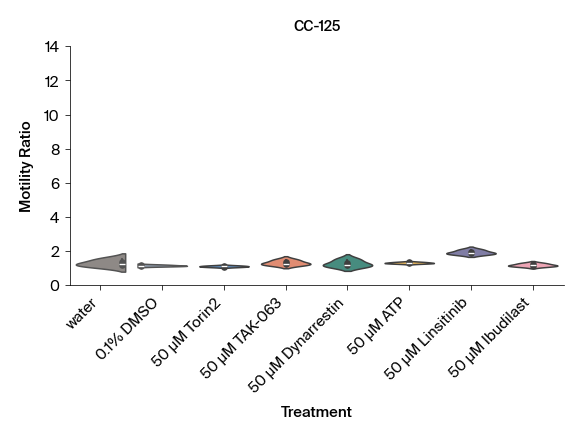


--- Generating Violin Plot for CC-2670 ---


/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_40545/3396199478.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Treatment", y="Frac_Avg_Min", data=strain_data[strain_data["Treatment"].isin(["water", "0.1% DMSO"])],
/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_40545/3396199478.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Treatment", y="Frac_Avg_Min", data=other_treatments,


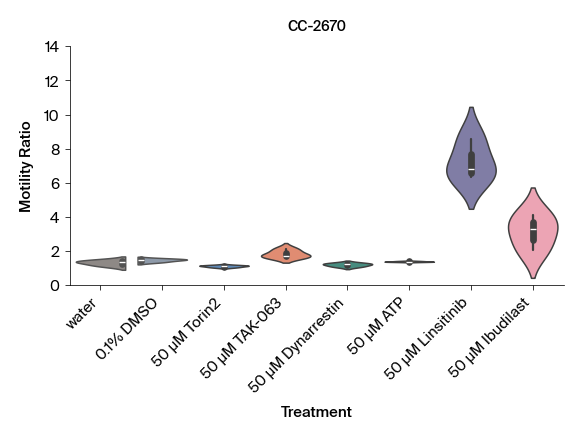


--- Generating Violin Plot for CC-3707 ---


/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_40545/3396199478.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Treatment", y="Frac_Avg_Min", data=strain_data[strain_data["Treatment"].isin(["water", "0.1% DMSO"])],
/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_40545/3396199478.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Treatment", y="Frac_Avg_Min", data=other_treatments,


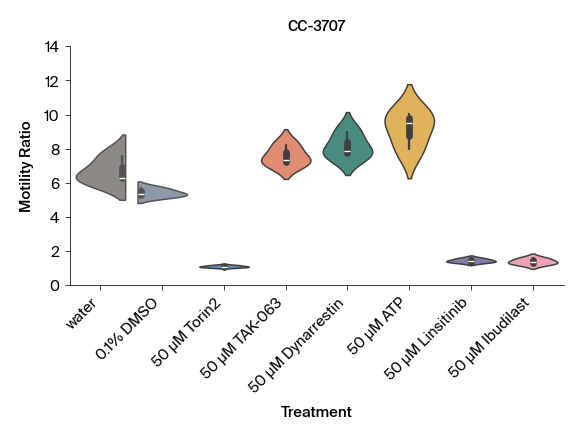

All violin plots have been generated and saved.


In [15]:
# Directory to save the SVG files
output_dir = "../results/linescan_drug_results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Generate Violin Plots for Each Strain
for strain in ["CC-125", "CC-2670", "CC-3707"]:
    print(f"\n--- Generating Violin Plot for {strain} ---")
    strain_data = min_intensity_df[min_intensity_df["Strain"] == strain]

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create split violin plot for water and 0.1% DMSO, adjusting for narrower violins
    sns.violinplot(x="Treatment", y="Frac_Avg_Min", data=strain_data[strain_data["Treatment"].isin(["water", "0.1% DMSO"])],
                   palette={"water": treatment_color_map["water"], "0.1% DMSO": treatment_color_map["0.1% DMSO"]},
                   split=True, inner="box", linewidth=1.5, ax=ax)

    # Add full violin plots for all other treatments (besides water and 0.1% DMSO)
    other_treatments = strain_data[~strain_data["Treatment"].isin(["water", "0.1% DMSO"])]
    sns.violinplot(x="Treatment", y="Frac_Avg_Min", data=other_treatments, 
                   palette=treatment_color_map, inner="box", linewidth=1.5, ax=ax)

    # Customize the plot
    plt.title(f"{strain}", fontsize=14)
    plt.xlabel("Treatment")
    plt.ylabel("Motility Ratio")

    # Disable y-axis grid lines
    ax.grid(False)  # This will turn off the dashed lines/gridlines from the y-axis

    # Set the y-axis limits to be the same across all plots (0 to 14)
    ax.set_ylim(0, 14)

    # Improve label placement, set spacing
    plt.xticks(rotation=45, ha="right")

    # Save the violin plot as an SVG file
    violin_plot_path = os.path.join(output_dir, f"violin_plot_{strain}_Frac_Avg_Min.svg")
    plt.tight_layout()
    plt.savefig(violin_plot_path, format="svg")
    plt.show()

print("All violin plots have been generated and saved.")